<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "" #@param {type:"string"}
Student_full_name = "" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [12, 8] 

# Improve the Jupyter Notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [8]:
# Load data
house_train = pd.read_csv("house_train.csv")
house_test = pd.read_csv("house_test.csv")
true_price = pd.read_csv("true_price.csv")

# Combine the training and test data
data = pd.concat([house_train, house_test], ignore_index = True)

# Add house value to the dataset
data = data.merge(
    true_price,
    left_on = "ad_id",
    right_on = "Id",
    how = "inner")

# Split into independent and dependent values
X = data.drop("Expected", axis = 1)
y = data["Expected"]

In [9]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

X_train["cost"] = y_train

In [10]:
## create train data frame
# use meaningful names
dftrain_ = DataFrame(dict(
    bathrooms=X_train["bathrooms"], 
    beds=X_train["beds"],
    ber_classification=X_train["ber_classification"], 
    latitude=X_train["latitude"],
    longitude=X_train["longitude"],
    property_type=X_train["property_type"],
    surface=X_train["surface"],
    #area=X_train["area"],
    cost=y_train))

In [11]:
## create test data frame
# no cost included

dftest_ = DataFrame(dict(
    bathrooms=X_test["bathrooms"], 
    beds=X_test["beds"],
    ber_classification=X_test["ber_classification"], 
    latitude=X_test["latitude"],
    longitude=X_test["longitude"],
    property_type=X_test["property_type"],
    surface=X_test["surface"],
    #area=X_test["area"]
))

In [12]:
def pre_processing_features(df, data):
    """
    Function to preprocess features.
    This includes One-Hot Encoding and 
    encoding columns.

    Creating a function as will be applied to both 
    Training and Testing data.

    ::param df: (pandas dataframe)
    ::param data: (pandas dataframe)
        Data to use to fill empty values and to encode
        Using Training data to not bias results
    ::param ber_dict: (dict)
    ::return: (pandas dataframe)
    """
    # Creating a mapping from ber letter to number
    # ber classification is ordinal
    ber_numbers = sorted(data.ber_classification.fillna(
        data.ber_classification.mode()[0]).unique())
    ber_dict = dict(zip(ber_numbers, range(len(ber_numbers))))
    
    # One Hot Encoding
    df = pd.get_dummies(df, columns = [
        "property_type",
        #"area"
    ])
    
    # Encoding
    # Fill NaN values with mode
    df["ber_classification"] = df["ber_classification"]\
        .map(ber_dict)\
        .fillna(ber_dict[data.ber_classification.mode()[0]])
    
    return df

In [13]:
# Addply preprocessing
dftrain = pre_processing_features(dftrain_, X_train)
dftest = pre_processing_features(dftest_, X_train)

# Change the Test column so that they align with the train columns
# This is incase there are different values un the One Hot Encoding
for col in list(set(dftrain.columns) - set(dftest.columns)):
    if col != "cost":
        print(f"Test data was missing: {col}")
        dftest[col] = 0   
        
for col in list(set(dftest.columns) - set(dftrain.columns)):
    print(f"Removing from Test data: {col}")
    dftest = dftest\
        .drop(col, axis = 1)

Test data was missing: property_type_studio


In [14]:
## create expected cost data frame
# the cost is in another file
dfcost = DataFrame(dict(cost=y_test))
# show first data frame rows 
dfcost.head()

,cost
300,325000.0
8,295000.0
348,295000.0
62,695000.0
441,900000.0


### Train dataset

In [15]:
syntPath = "./house/"
filename1 = "Train.csv"
filename2 = "Test.csv"
filename3 = "Cost.csv"

# training dataset: 
training_file = syntPath+filename1
# test dataset: 
testing_file = syntPath+filename2
# cost dataset: 
cost_file = syntPath+filename3

In [16]:
# show first data frame rows 
dftrain.head()

,bathrooms,beds,ber_classification,latitude,longitude,surface,cost,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
372,3.0,4.0,6.0,53.268321,-6.160097,145.0,750000.0,0,0,1,0,0,0,0,0,0,0
109,1.0,3.0,6.0,53.572920,-6.107007,131.6,495000.0,0,0,0,0,0,1,0,0,0,0
254,2.0,3.0,8.0,53.315586,-6.386911,116.0,425000.0,0,0,0,0,0,1,0,0,0,0
285,3.0,3.0,3.0,53.326126,-6.244472,232.0,1500000.0,1,0,0,0,0,0,0,0,0,0
72,3.0,3.0,7.0,53.533342,-6.092949,103.0,298000.0,0,0,0,0,0,1,0,0,0,0


In [17]:
# Generate descriptive statistics
dftrain.describe()

,bathrooms,beds,ber_classification,latitude,longitude,surface,cost,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,3.500000e+02,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,1.980000,2.868571,7.691429,53.357058,-6.247788,145.242307,5.797224e+05,0.288571,0.022857,0.114286,0.017143,0.065714,0.262857,0.022857,0.002857,0.197143,0.005714
std,1.131548,1.157948,3.001754,0.083148,0.086554,253.558025,6.351499e+05,0.453747,0.149662,0.318613,0.129989,0.248137,0.440816,0.149662,0.053452,0.398411,0.075485
min,0.000000,0.000000,0.000000,53.221348,-6.496987,33.500000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,6.000000,53.298716,-6.296838,71.025000,2.912375e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,8.000000,53.338500,-6.243572,97.000000,3.995000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,10.000000,53.383485,-6.186486,134.997500,5.837500e+05,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,6.000000,14.000000,53.619775,-6.064874,3035.142317,5.750000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Test dataset

In [18]:
# show first data frame rows 
dftest.head()

,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_terraced,property_type_townhouse,property_type_studio
300,2.0,2.0,6.0,53.376982,-6.277286,70.000000,1,0,0,0,0,0,0,0,0,0
8,2.0,2.0,4.0,53.275403,-6.298005,67.200000,1,0,0,0,0,0,0,0,0,0
348,1.0,3.0,13.0,53.360494,-6.197141,71.000000,0,0,0,0,0,0,0,1,0,0
62,3.0,4.0,12.0,53.297530,-6.181436,166.020000,0,0,0,0,0,1,0,0,0,0
441,0.0,0.0,8.0,53.366811,-6.313035,1618.742569,0,0,0,0,0,0,1,0,0,0


In [19]:
# Generate descriptive statistics
dftest.describe()

,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_terraced,property_type_townhouse,property_type_studio
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0
mean,2.026667,3.073333,8.380000,53.353646,-6.247966,181.126854,0.213333,0.026667,0.20000,0.020000,0.046667,0.286667,0.020000,0.173333,0.013333,0.0
std,1.048788,1.259043,2.822893,0.079148,0.093345,495.940132,0.411034,0.161647,0.40134,0.140469,0.211631,0.453719,0.140469,0.379803,0.115082,0.0
min,0.000000,0.000000,0.000000,53.235089,-6.492840,39.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,2.000000,7.000000,53.296350,-6.292990,75.200000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,3.000000,8.000000,53.340851,-6.243464,103.625000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.750000,4.000000,10.000000,53.379763,-6.175676,142.125000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
max,6.000000,7.000000,14.000000,53.614880,-6.096991,5746.536120,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### Expected Cost dataset

In [20]:
# Generate descriptive statistics
dfcost.describe()

,cost
count,1.500000e+02
mean,5.840996e+05
std,5.142075e+05
min,1.400000e+05
25%,3.250000e+05
50%,4.425000e+05
75%,6.450000e+05
max,4.750000e+06


# PIECEWISE REGRESSION

## Full Model

In [21]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = [
    "bathrooms",
    "beds",
    "latitude",
    "longitude",
    "surface",
    'cost']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)
#df_subset_train = dftrain.dropna(axis=0)

featest = [
    "bathrooms",
    "beds",
    "latitude",
    "longitude",
    "surface"
]
df_subset_test  =  dftest[featest].dropna(axis=0)
#df_subset_test  =  dftest.dropna(axis=0)

# cost
df_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

In [22]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [23]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.cost.values

In [24]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

#ylog = np.log(ys_train.astype('float'))
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [25]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    #like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 395.93


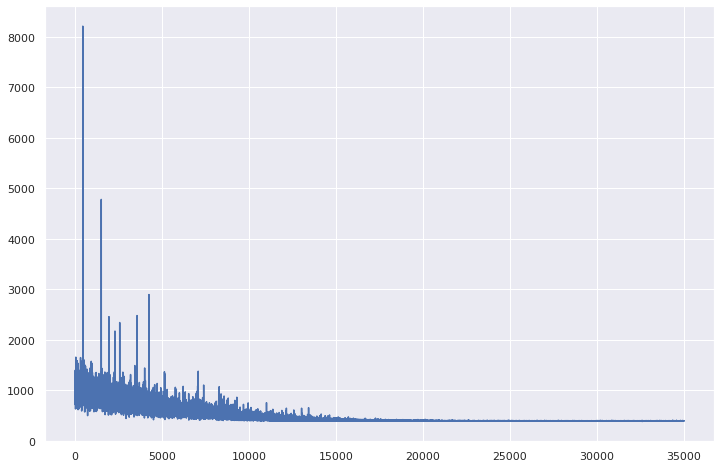

In [26]:
#number of iterations of the algorithms
iter = 35000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [27]:
# samples from the posterior
posterior = approximation.sample(5000)

In [28]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  189418.71905981773
MAPE =  0.2813681051292424


## Clustering

### Full Model

### Clusters

#### Optimal Cluster Components

In [29]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


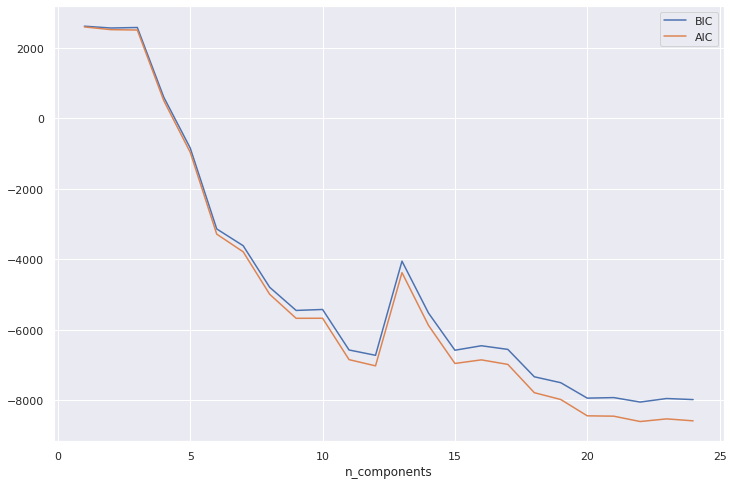

In [30]:
from sklearn.mixture import GaussianMixture

# We will use Akaike information criterion (AIC) 
# or the Bayesian information criterion (BIC) to choose the best number of components when
# clustering.

# Using https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html as inspiration.

# Using Long/Lat for the Gaussian Clustering

n_components = np.arange(1, 25)
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_ind)
          for n in n_components]

plt.plot(n_components, [m.bic(X_ind) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_ind) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');


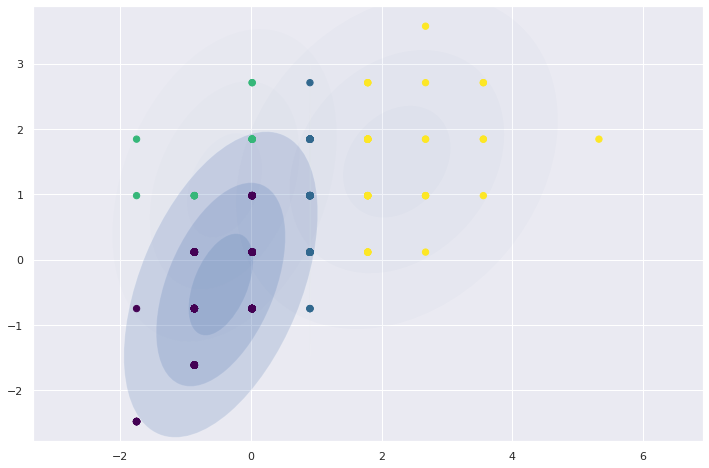

In [31]:
# Plot 2d GaussianMixture density distributions

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_ind)

#### Apply Cluster Components

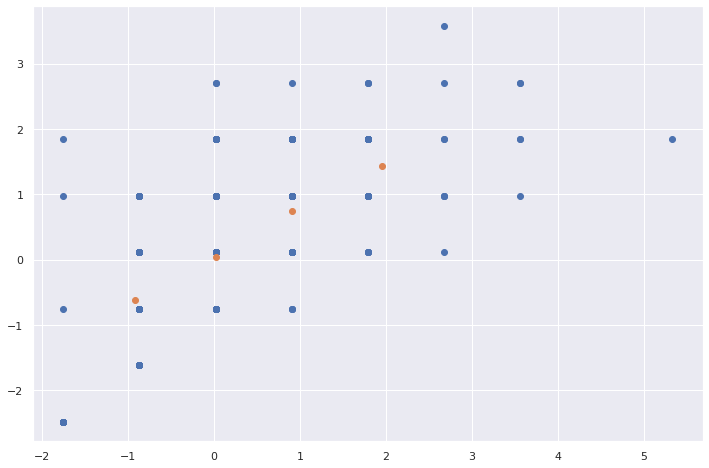

In [32]:
# training gaussian mixture model 

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [33]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 133, 1: 65, 2: 120, 3: 32}

In [34]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 49, 1: 26, 2: 63, 3: 12}

In [35]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)


In [36]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)


In [37]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)


In [38]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)


## Piecewise Model

In [39]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 198.18


In [40]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 109.34


In [41]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 168.42


In [42]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 63.585


In [43]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



##Simulations

### Only Cluster 0

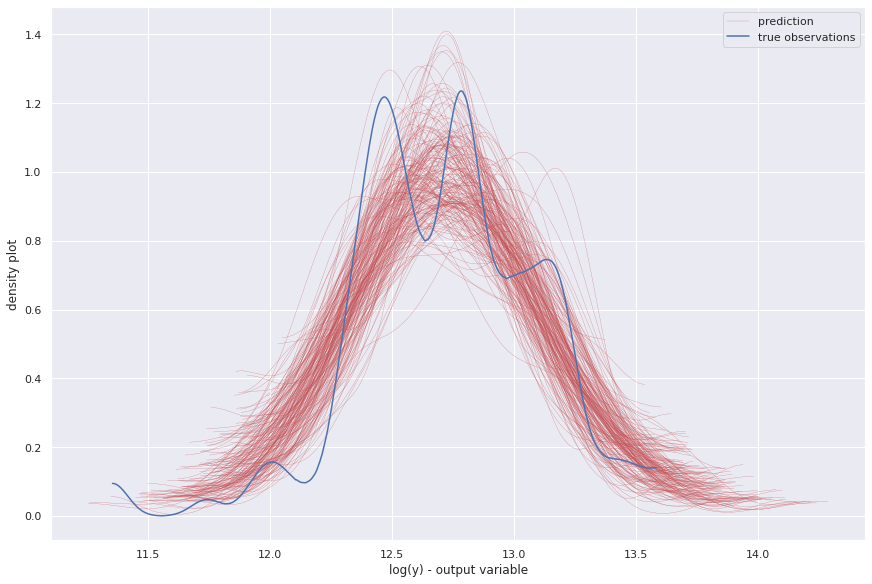

In [44]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

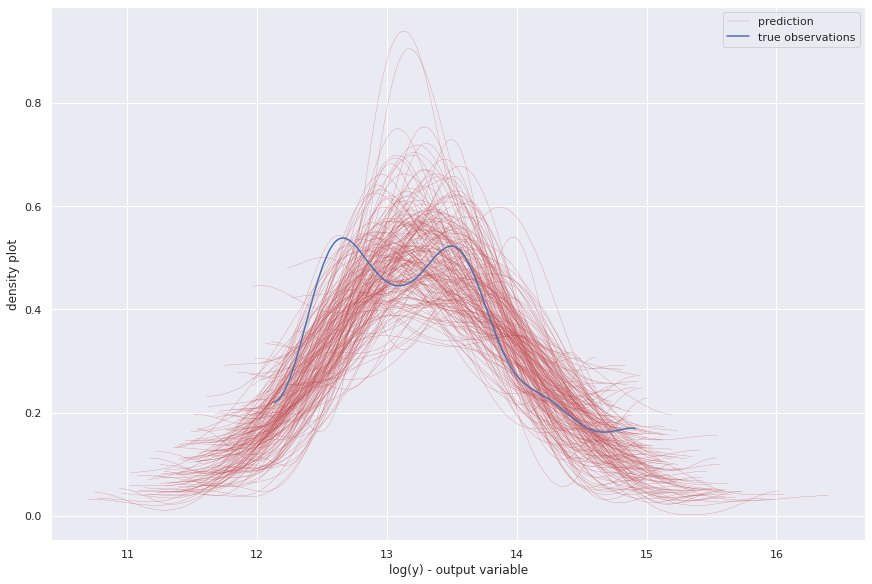

In [45]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

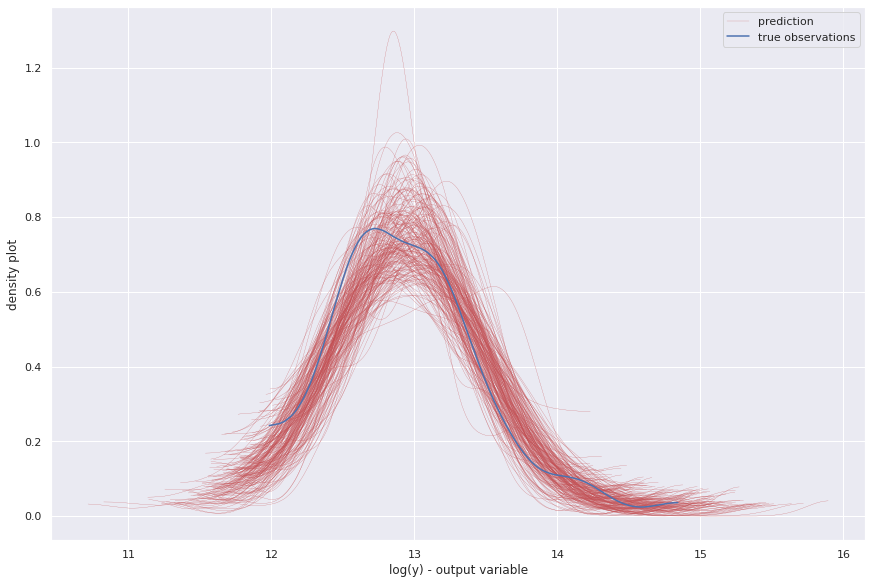

In [46]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

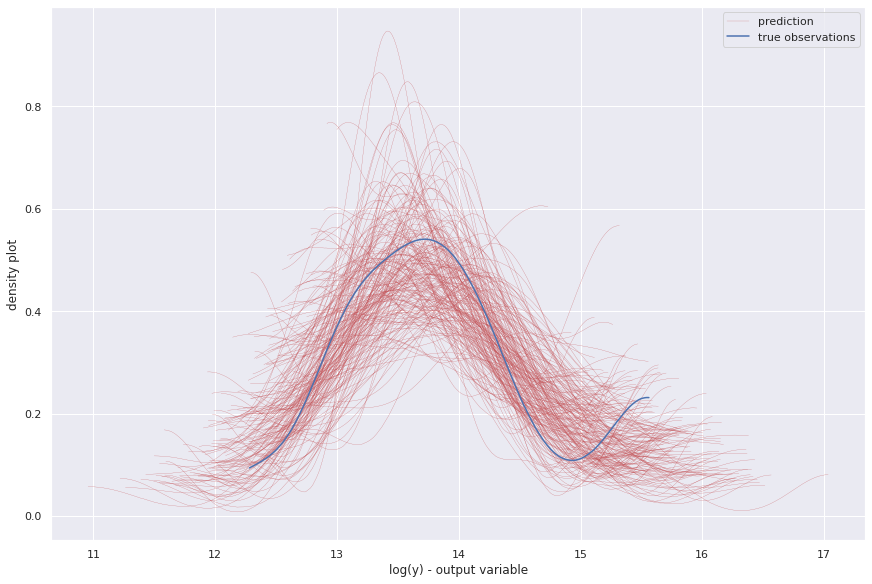

In [47]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

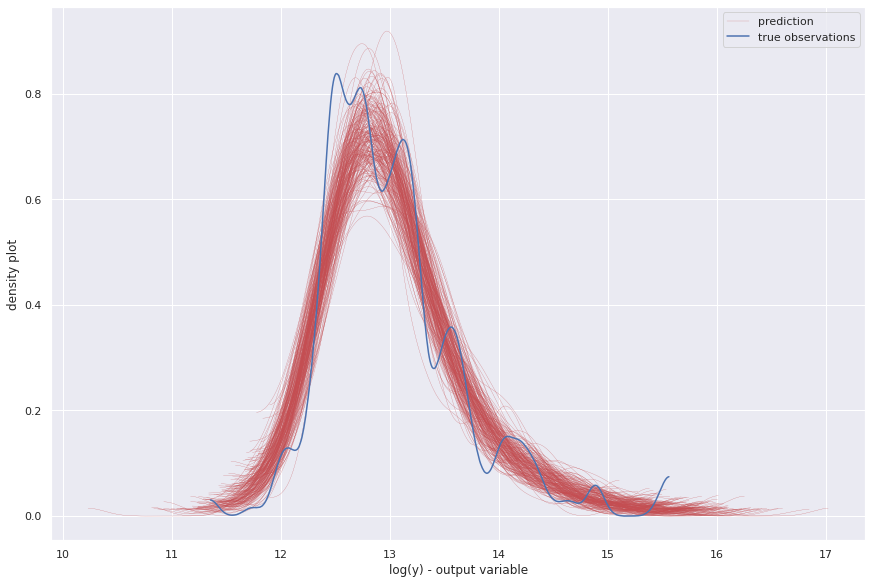

In [48]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [49]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 49 , MAE Cluster0= 106233.99914223702
Size Cluster1 26 , MAE Cluster1= 314574.9004597264
Size Cluster2 63 , MAE Cluster2= 121533.42272854791
Size Cluster3 12 , MAE Cluster3= 386154.43440824933
MAE= 171165.81476480007


### PPC on the Test set



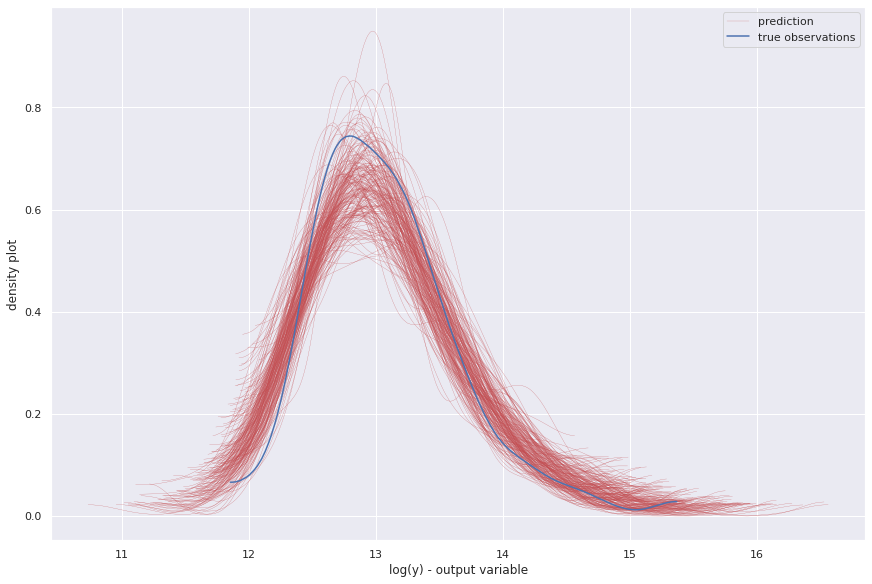

In [50]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY